In [769]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.stats import zscore
from sklearn.metrics import silhouette_score,classification_report
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
plt.style.use('fivethirtyeight')

## Problem Statement:

Based on given data of visitors browsing for online shopping, the objective is to build different clusters to know whether person is only browsing and visiting multiples pages or also generating revenue for the shoppers as well.  
The idea is to create clusters and convert it into a classification problem, and then build models. The quality of models is analyzed using different criteria.


In [770]:
df = pd.read_csv('online_shoppers_intention.csv')

### DATA DESCRIPTION

Data is taken from https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset#

Special thanks to this paper : https://link.springer.com/article/10.1007/s00521-018-3523-0

**CONTINUOUS FEATURES**

**Administrative** -Integer -Number of different pages visited related to the administrative concerns of the website

**Informational** -Integer -Number of different pages visited related to the information of the website and other useful contents of the website

**ProductRelated** - Integer -Number of different pages visited related to different products of the website.

**BounceRate** - Float - Percentage of users who left the website from the landing page

**ExitRate** - Float - Percentage of users who left from the page the visit

**Page Values** - Float - Page Value is the average value for a page that a user visited before making a transaction.

**SpecialDay** - Float\
                  0 – day of the session is not within 10 days of a special day.\
Between 0.1 and 0.5 – day of the session is between 10 days and 5 days away from a special day.\
Between 0.6 and 0.9 – day of the session is between 4 days and 1 day away from a special day.\
1 – day of the session is a special day.\

The features Bounce Rates, Exit Rates and Page Values are terms of Google analytics that are used to determine the performance of a website. The bounce rate is used to show the percentage of single page sessions out of all the sessions. The exit rate shows us the percentage of people who left from a page. Page value gives us the average value of the transaction to all the pages visited which is equally distributed to all pages.

**CATEGORICAL FEATURES**

**Administrative_Duration** -Integer\
Time spent on Administrative pages in seconds\
                    0 – No time was spent on the page\
                    1 - Less time of under 233 was spent on the page\
                    2 – More time of  over 233 was spent on the page\
                    
**Informational_duration** - Integer\
Time spent on Informational pages in seconds\
                    0 – No time was spent on the page\
                    1- More time was spent on the page\
                    
**ProductRelated_Duration** - Integer\                    
Time spent on pages related to products in seconds\                 
                                      0 – No time was spent on the page\
                                      1 - Less time of under 3384 was spent on the page\
                                      2 – More time of  over 3384 was spent on the page\
                                      
**Browse** - Integer -ID of bowsers from which the session took place

**Region** - Integer - ID of Regions from which the session took place

**Traffic Type** -Integer - ID of different types of sources from which the users landed on the website

**User Type** -String - Whether the user is a returning user or a new user or of any other type

**Revenue** - Boolean - Whether the user contributed to the revenue by purchasing or not

**Weekend** - Boolean - Whether the session was on a weekend or not

**OperatingSystems** - Integer - ID of the operating systems used

**Month** - String - Month of the visit

In [771]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [772]:
df.shape

(12330, 18)

The dataframe has 12330 rows and 18 columns.

### Data pre-processing

**Checking for null values**

In [773]:
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

**Checking the data-type of all the variables**

In [774]:
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [775]:
df[['Weekend','Revenue']]= df[['Weekend','Revenue']].astype('int') 
#Using astype('int') directly converts boolean to 0s and 1s

In [776]:
df['VisitorType'].value_counts()

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

**Separating numerical and categorical columns**

I feel that partitioning the dataset into numerical and categorical variables would be helpful for checking outliers, and model building as well. So let's do the same.

In [777]:
df_numerical  = df[['Administrative','Administrative_Duration','Informational','Informational_Duration',
              'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues']]
df_categorical = df[list(set(df.columns) - set(df_numerical.columns))]

**Checking for outliers**

We can use a *for* loop and plot all the numerical columns in a boxplot, preferably in a 5 x 2 subplot arrangement.

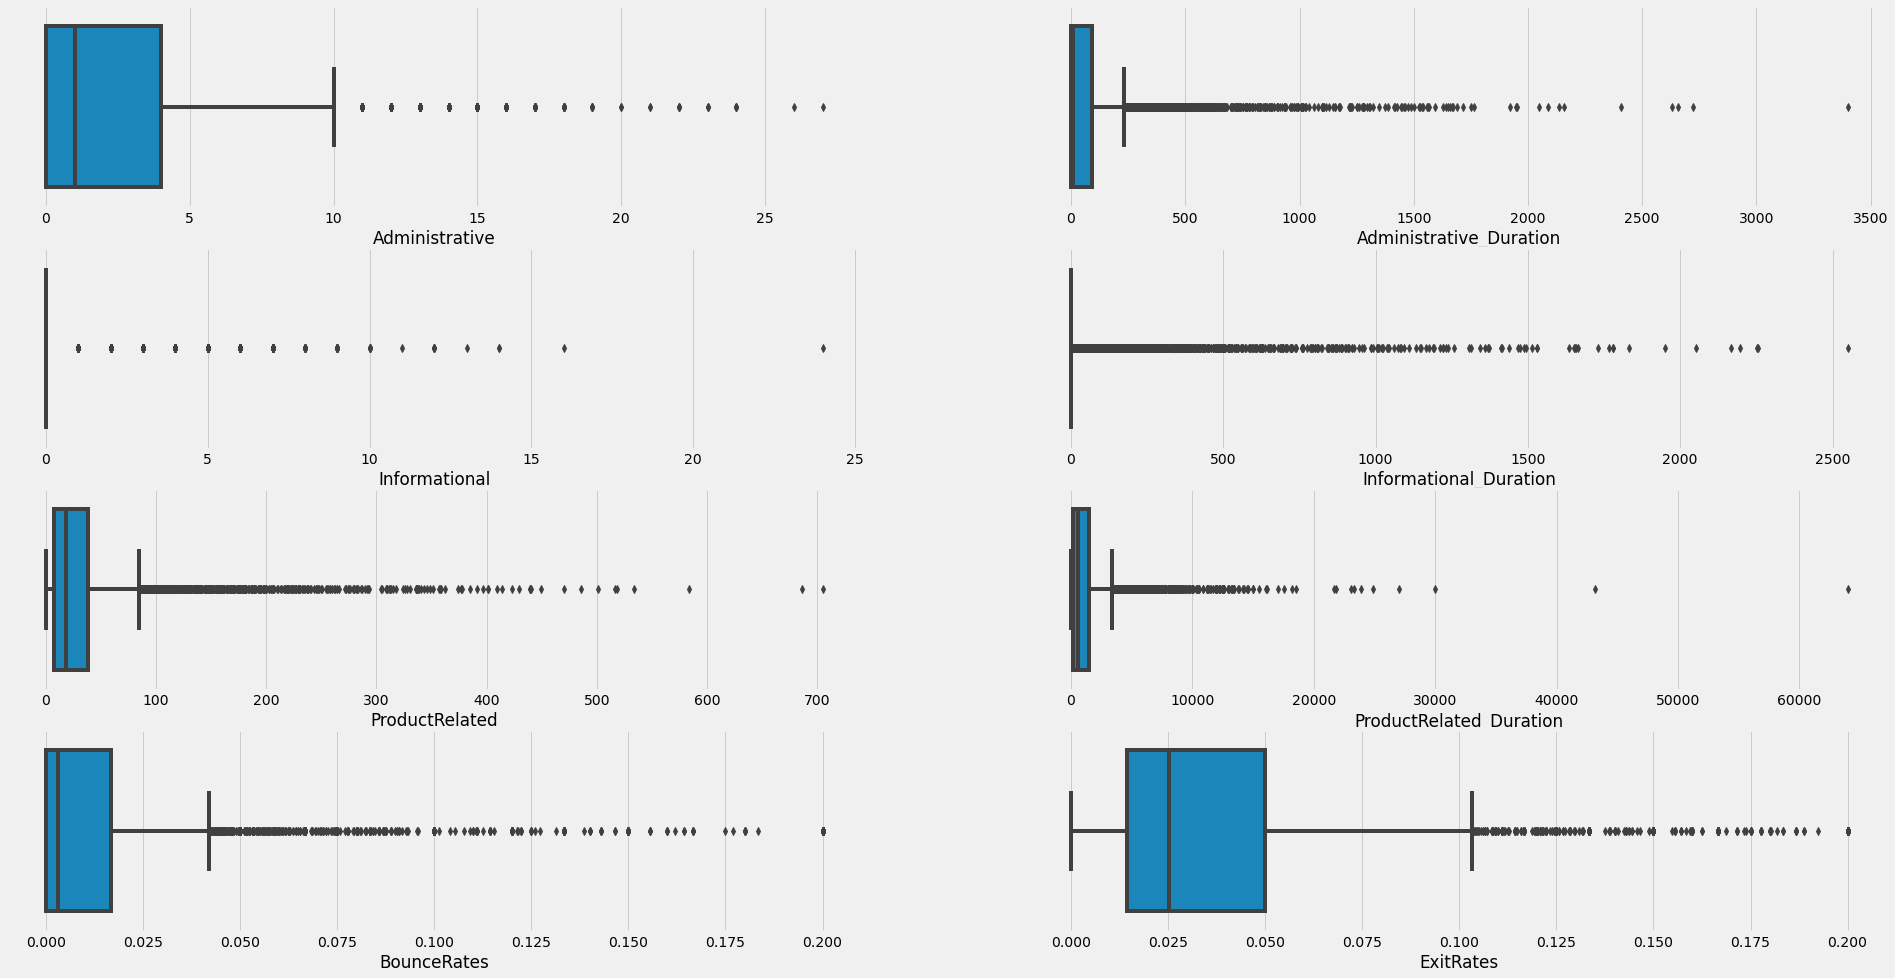

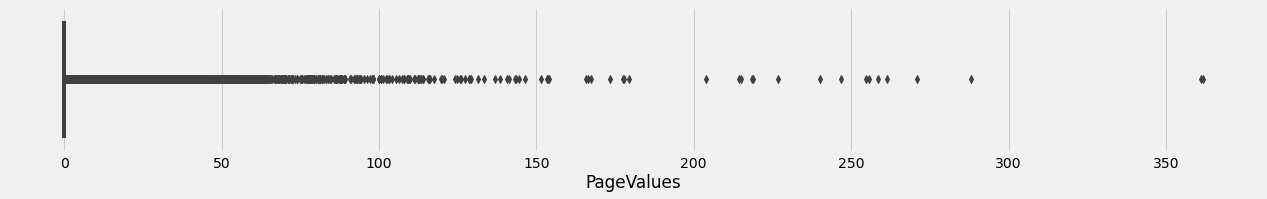

In [778]:
plt.figure(figsize=(30,20))
for j,i in enumerate(df_numerical.columns[:-1]):
    plt.subplot(5,2,j+1)
    sns.boxplot(df[i])
plt.show()
plt.figure(figsize=(20,2.5))
sns.boxplot(df['PageValues'])
plt.show()

I tried removing the entire DataFrame's outliers using `DataFrame[~((DataFrame<Min_limit)|(DataFrame>Max_limit)).any(axis=1)]`but it results in removal of all the values which are non-zero. Therefore we will try removing outliers from specific columns, and make sure we don't get any null values added.

We'll remove outliers from the following variables:
- Administrative
- ProductRelated
- BounceRate
- ExitRate

In [779]:
import statistics
def remove_outliers(x):
    qua = statistics.quantiles(df[x])
    IQR = qua[2] - qua[0]
    Max_limit = qua[2] + (1.5*IQR)
    Min_limit = qua[0] - (1.5*IQR)
    return df[(df[x] > Min_limit) & (df[x] < Max_limit)]

In [780]:
df = remove_outliers('Administrative')
df = remove_outliers('ProductRelated')
df = remove_outliers('BounceRates')
df = remove_outliers('ExitRates')
df.shape

(9042, 18)

In [781]:
12330 - 9042

3288

3288 values have been removed.

**Checking for null values again**

In [782]:
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [783]:
df.reset_index(inplace=True) # resetting the index.

In [784]:
df.drop(columns=['index'],axis=1,inplace=True)

In [785]:
df_numerical  = df[['Administrative','Administrative_Duration','Informational','Informational_Duration',
              'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues']]

In [786]:
df_categorical = df[list(set(df.columns) - set(df_numerical.columns))]

To check the integrity of data

In [787]:
print(df_numerical.shape)
print(df_categorical.shape)

(9042, 9)
(9042, 9)


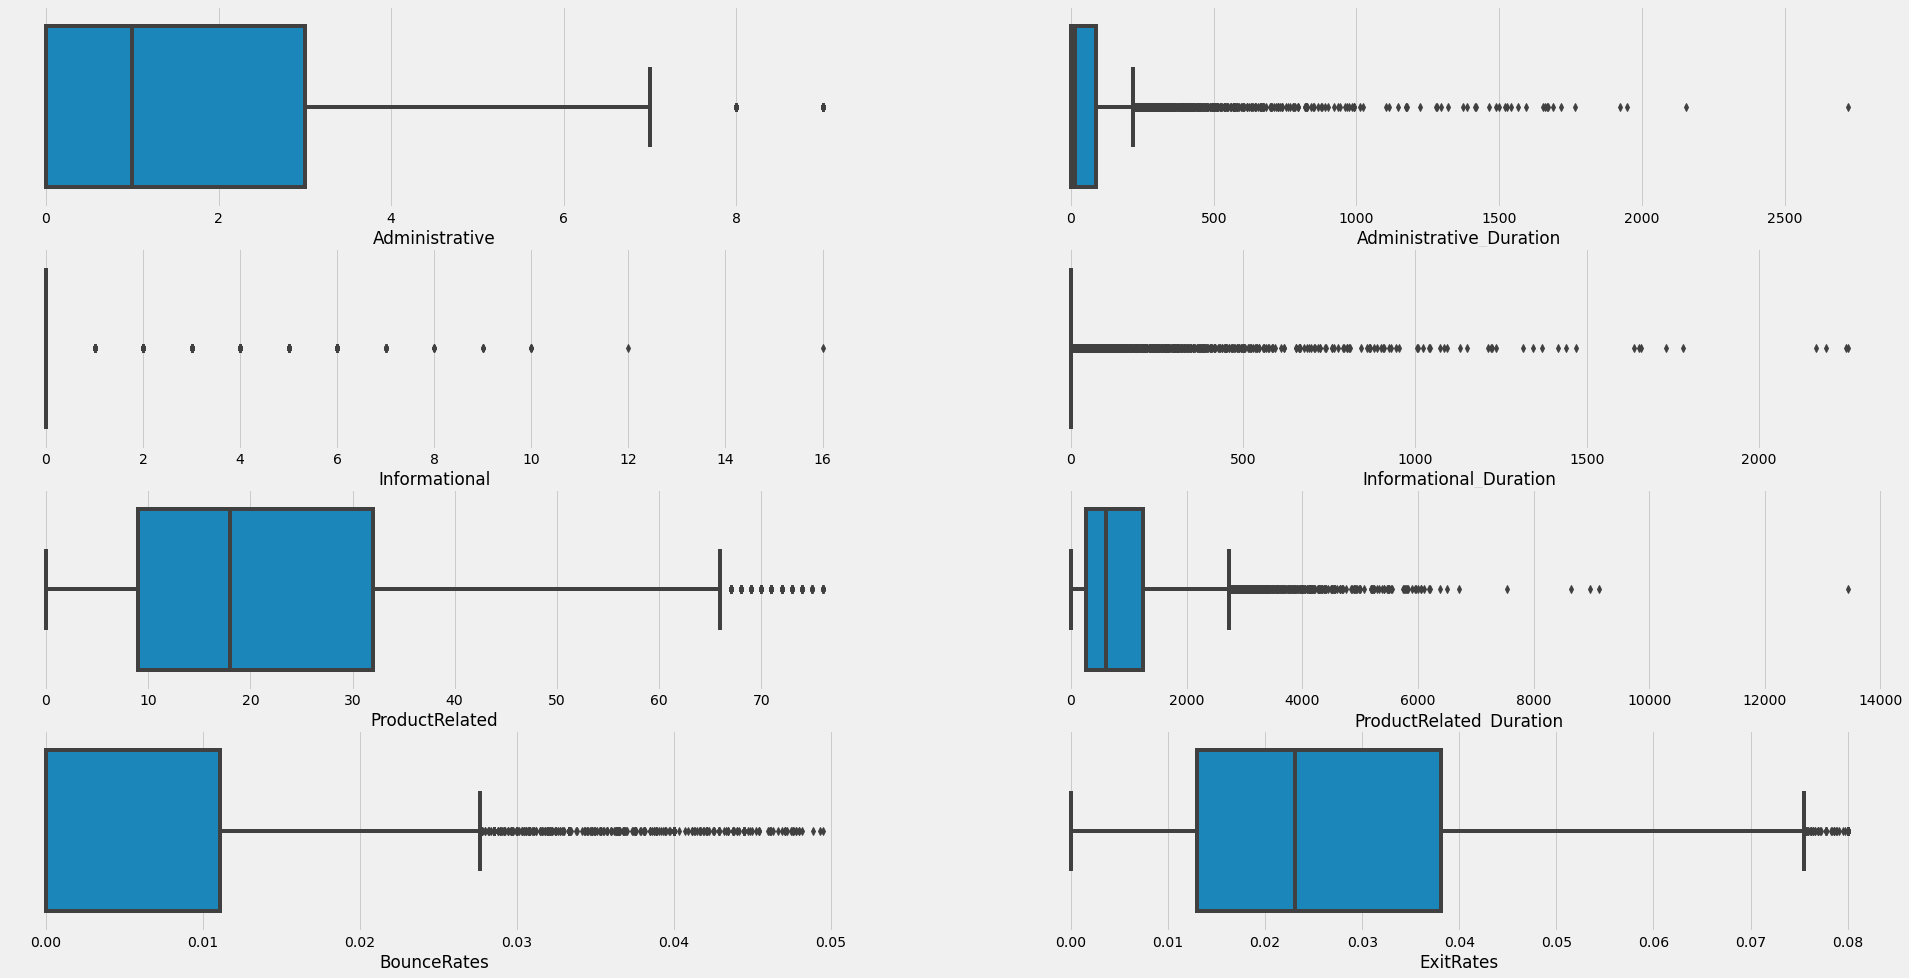

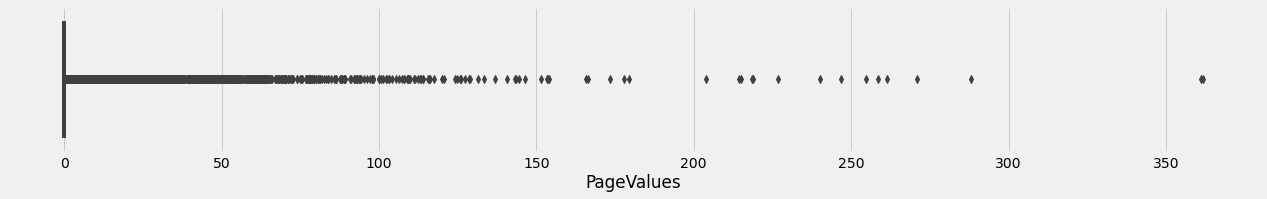

In [788]:
plt.figure(figsize=(30,20))
for j,i in enumerate(df_numerical.columns[:-1]):
    plt.subplot(5,2,j+1)
    sns.boxplot(df[i])
plt.show()
plt.figure(figsize=(20,2.5))
sns.boxplot(df['PageValues'])
plt.show()

We are done with the data pre-processing. Let's move on to some exploratory data analysis to get some insights about the data.

**EXPLORATORY DATA ANALYSIS**

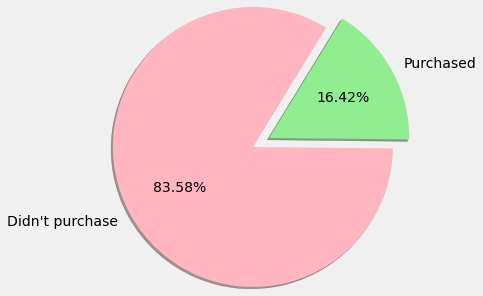

0    7557
1    1485
Name: Revenue, dtype: int64


In [789]:
plt.pie(df.Revenue.value_counts(),labels=['Didn\'t purchase','Purchased'],
        autopct='%1.2f%%',colors=['lightPink','lightGreen'],explode=[0,0.2],
        shadow=True,startangle=58.5,radius=1.5,)
plt.show()
print(df.Revenue.value_counts())

83.6 % of the people didnt purchase after clicking on the webpage, while 16.4% did.

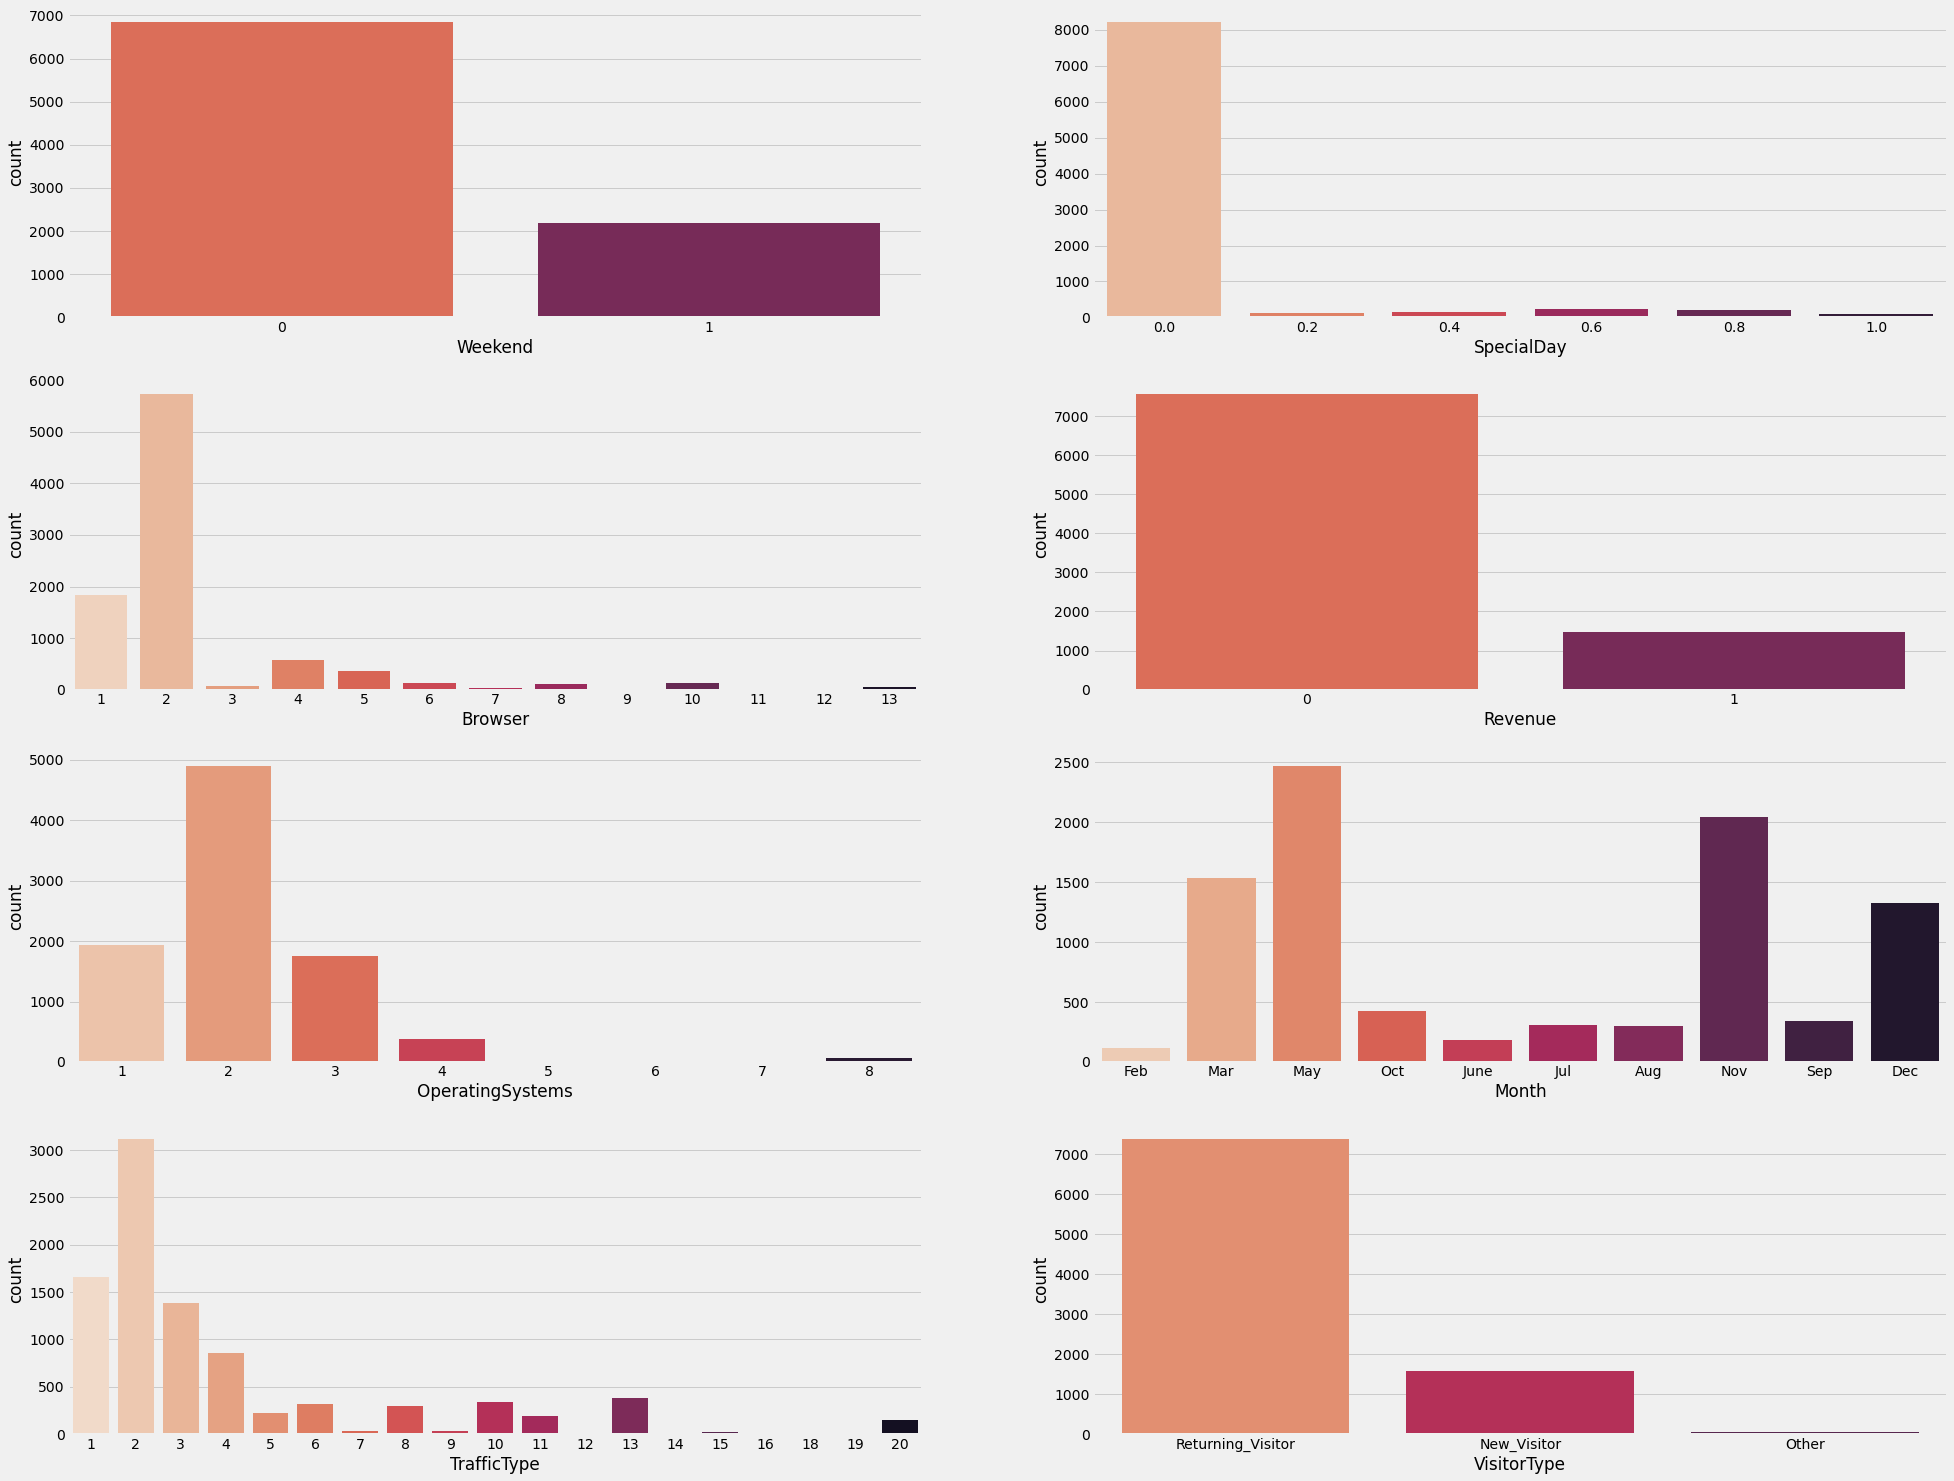

In [790]:
plt.figure(figsize=(30,50))
for j,i in enumerate(df_categorical.columns[:-1]):
    plt.subplot(8,2,j+1)
    sns.countplot(df_categorical[i],palette="rocket_r")
plt.show()

We are able to gain quite a bit of insight from the above plots on categorical variables.
- Count of special days\
    We can see that visitors checkout the webpage right on special days. 
- Popularity of months\
    The months March, May, November and December are the most popular, accounting for 81.5% of the total visits. Since this dataset is from Turkey, I presume the reason is because of Ramadan & Eid falling in one of these months.
- Visitor Type\
    A large part of visitors seem to be faithfuls, with 81.7% of the total being returning visitors.

In [791]:
df_categorical['Month'].value_counts(normalize=True)[:4]*100

May    27.272727
Nov    22.583499
Mar    16.943154
Dec    14.709135
Name: Month, dtype: float64

In [792]:
df_categorical['VisitorType'].value_counts(normalize=True)*100

Returning_Visitor    81.785003
New_Visitor          17.540367
Other                 0.674630
Name: VisitorType, dtype: float64

In [793]:
df_categorical['Weekend'].value_counts()

0    6848
1    2194
Name: Weekend, dtype: int64

In [794]:
pd.crosstab(index = df['Revenue'],columns=df['Weekend'])

Weekend,0,1
Revenue,,
0,5767,1790
1,1081,404


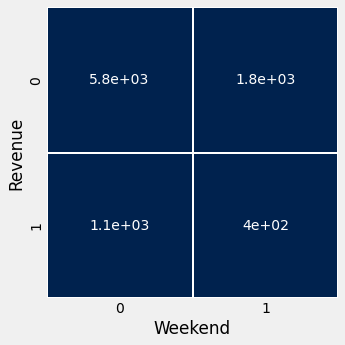

In [795]:
plt.figure(figsize=(5,5))
sns.heatmap(pd.crosstab(index = df['Revenue'],columns=df['Weekend']),
            annot=True,cbar=False,linecolor='White',linewidths=2,square=True,
            cmap='cividis',vmin=1,vmax=1)
plt.show()

In [796]:
print(f'{1081+404} purchases have been made over the year')

1485 purchases have been made over the year


In [797]:
#Average purchase on a weekend
print(f'The average purchases on a weekend is {round((404/52),2)}')
#Average visits on a weekend
print(f'The average visits on a weekend is {round((2194/52),2)}')

The average purchases on a weekend is 7.77
The average visits on a weekend is 42.19


In [798]:
#Average purchase on a weekday
print(f'The average purchases on a weekday is {round((1081/313),2)}')
#Average visits on a weekday
print(f'The average visits on a weekday is {round((6848/313),2)}')

The average purchases on a weekday is 3.45
The average visits on a weekday is 21.88


- From the above data, we can see that there is a 18.41% chance that a visitor will purchase on a weekend.
- Also, there's a 15.76% chance that a visit is converted into a sale on a weekday.

We can see that average purchase/visit ratio on a weekend is higher than on a weekday.

In [799]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,1,0
1,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2,1,3,Returning_Visitor,0,0
2,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.0,0.4,Feb,2,4,1,2,Returning_Visitor,0,0
3,0,0.0,0,0.0,3,395.000000,0.000000,0.066667,0.0,0.0,Feb,1,1,3,3,Returning_Visitor,0,0
4,0,0.0,0,0.0,16,407.750000,0.018750,0.025833,0.0,0.4,Feb,1,1,4,3,Returning_Visitor,0,0


In [800]:
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                      int32
Revenue                      int32
dtype: object

In [801]:
specday = df.groupby('SpecialDay')[['ProductRelated','ProductRelated_Duration','Revenue']].sum()

In [802]:
specday

,ProductRelated,ProductRelated_Duration,Revenue
SpecialDay,,,
0.0,188107,7.400488e+06,1415
0.2,2969,1.147307e+05,12
0.4,3827,1.468018e+05,11
0.6,5095,1.775897e+05,26
0.8,5525,2.114098e+05,11
1.0,2620,8.637563e+04,10


188107 tangential visits to the products have happened on a special day, which is significantly higher than on other days, which makes sense since people would be looking at a variety of products to get their purchase done.

In [803]:
specday['ProductRelated']/specday['Revenue']

SpecialDay
0.0    132.937809
0.2    247.416667
0.4    347.909091
0.6    195.961538
0.8    502.272727
1.0    262.000000
dtype: float64

In [804]:
df.groupby('SpecialDay')[['PageValues','Revenue']].sum()

,PageValues,Revenue
SpecialDay,,
0.0,58329.003460,1415
0.2,513.404334,12
0.4,473.461824,11
0.6,770.986612,26
0.8,347.704634,11
1.0,255.490543,10


In [805]:
df.groupby('Weekend')[['BounceRates','ExitRates']].mean()*100

,BounceRates,ExitRates
Weekend,,
0,0.691889,2.753725
1,0.668983,2.546014


We can see that weekends have no effect on how much a customer is going to move to another page or exit the page.

Okay enough of the insights, let's get into clustering.

### Building a clustering model

In [806]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [807]:
from scipy.stats import zscore

In [808]:
z_X = zscore(df_numerical)

In [809]:
Inertia = [KMeans(n_clusters=i,random_state=100).fit(z_X).inertia_ for i in range(1,9)]

**Building an elbow plot**

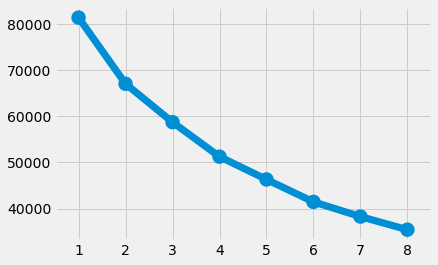

In [810]:
sns.pointplot(x=list(range(1,9)),y=Inertia,markers='.')
plt.grid(True)
plt.show()

It kinda looks like the plot bends at either 2nd or 3rd clusters. However, let's try using the silhoutte score.

**Using silhouette score to decide on the number of clusters.**

In [811]:
from sklearn.metrics import silhouette_score

In [812]:
for i in range(2,9):
    lab = KMeans(n_clusters= i, random_state= 100).fit(z_X).labels_
    score = silhouette_score(z_X, lab, random_state= 100)
    print (f"For {i} clusters the silhouette score is {score}")

For 2 clusters the silhouette score is 0.2788175464721106
For 3 clusters the silhouette score is 0.21757516227657814
For 4 clusters the silhouette score is 0.2386668360017342
For 5 clusters the silhouette score is 0.24337002980844447
For 6 clusters the silhouette score is 0.2579375304146632
For 7 clusters the silhouette score is 0.25104367051156234
For 8 clusters the silhouette score is 0.25043232311569913


Silhouette range is from -1 to 1.\
We can see that the optimal no. of clusters is 2.\
We can now build a K-Means Clustering model with 2 clusters.

**Building a K-Means model**

In [813]:
KM_Model = KMeans(n_clusters=2,random_state=100).fit(z_X)

In [814]:
df = pd.concat([df,pd.DataFrame({'KM_Labels':list(KM_Model.labels_)})],axis=1)

In [815]:
df.head(1)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,KM_Labels
0,0,0.0,0,0.0,10,627.5,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,1,0,1


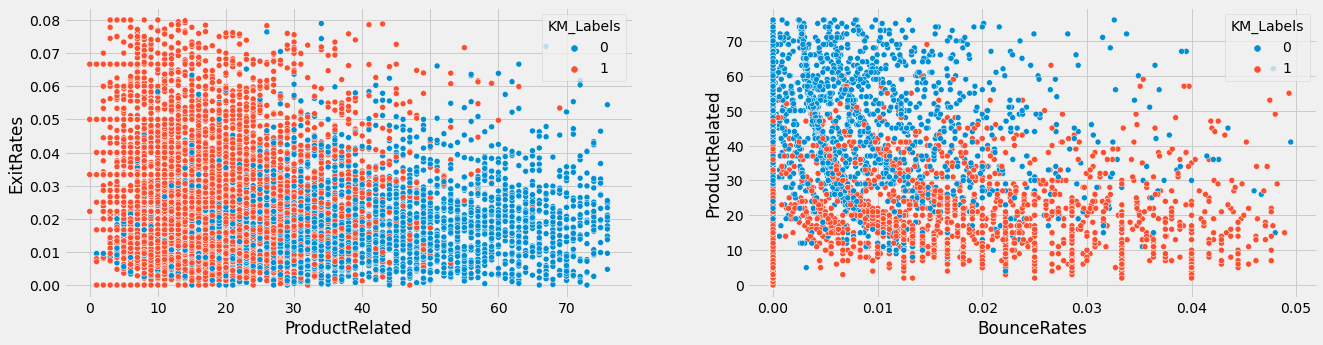

In [816]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.scatterplot(x=df_numerical['ProductRelated'],y=df_numerical['ExitRates'],hue=df['KM_Labels'])
plt.subplot(1,2,2)
sns.scatterplot(x=df_numerical['BounceRates'],y=df_numerical['ProductRelated'],hue=df['KM_Labels'])
plt.show()

We can see that the clusters are fairly separated.

Now, lets perform Agglomerative Clustering and build a dendrogram for it.

**Building a Agglomerative Clustering model**

In [817]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

Using a for loop to build a dendrogram, to find the correct linkage method.

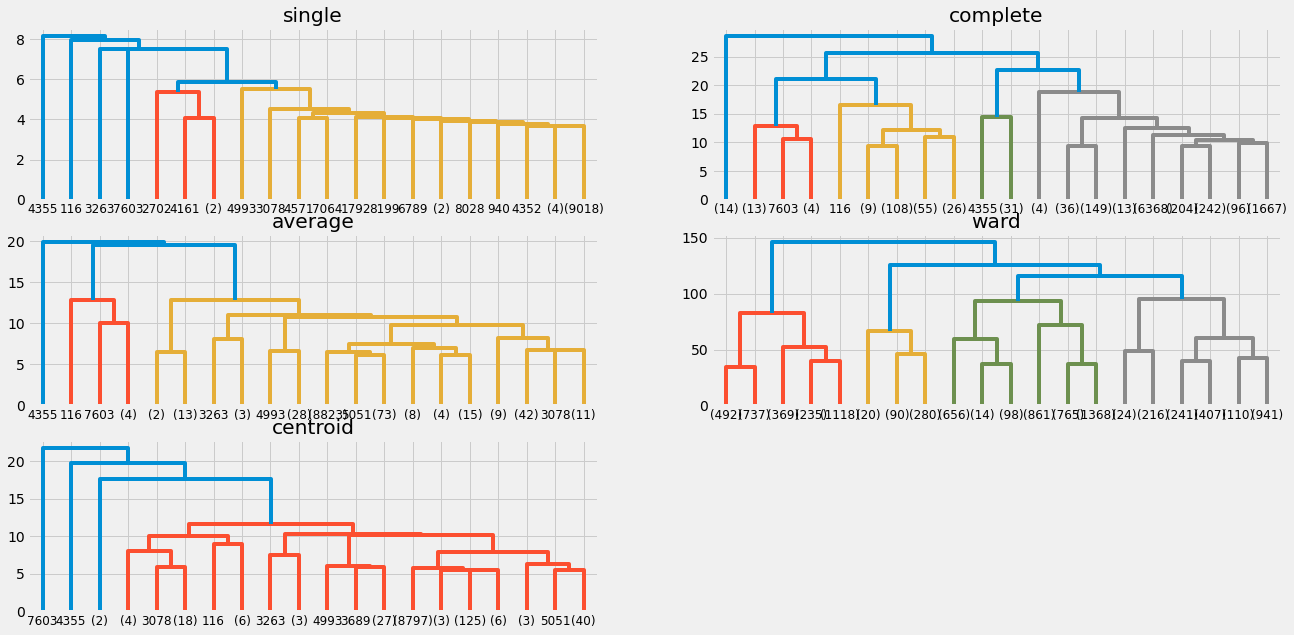

In [818]:
method = ['single','complete','average','ward','centroid']
plt.figure(figsize=(20,10))
for j,i in enumerate(method):
    z = linkage(z_X,i)
    plt.subplot(3,2,j+1)
    dendrogram(z,truncate_mode='lastp',p=20) # truncate_mode shows only the 'p' no. of clusters instead of every data points from the start 
    plt.title(i)
plt.show()

- Single linkage method seems to have a lot of chaining effect, as does centroid
- Ward and complete linkages have very good clusters.

In [819]:
method = ['single','complete','average','ward','centroid']
for i in method:
    z = linkage(z_X,i)
    c, coph_dist = cophenet(z, pdist(z_X))
    print('Cophenetic coefficient for',i,'is - ',c)

Cophenetic coefficient for single is -  0.8020067568664652
Cophenetic coefficient for complete is -  0.7039397390986317
Cophenetic coefficient for average is -  0.8616518209779648
Cophenetic coefficient for ward is -  0.33033117748999186
Cophenetic coefficient for centroid is -  0.8346658382239392


Despite the cophenetic score for ward being poor, we'll use it since by dendrogram, it had the most lucid clusters, and it is the industry standard anyways.

In [820]:
Agg_model = AgglomerativeClustering(n_clusters=2).fit(z_X)

In [821]:
label_df=pd.DataFrame({'KM_Labels':df['KM_Labels']})

In [822]:
label_df['Agg_Labels'] = Agg_model.labels_

In [823]:
label_df.head()

,KM_Labels,Agg_Labels
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


**Building a DBSCAN model (Density Based Clustering)**

In [824]:
DBSCAN_model = DBSCAN(eps=0.8,min_samples=15).fit(z_X)

In [825]:
pd.DataFrame({'DB_Labels':DBSCAN_model.labels_}).value_counts()

DB_Labels
 0           5849
-1           3092
 1             68
 2             33
dtype: int64

We get 4 labels, out of which -1 are all noise. Hence only 3 clusters are logical.

Gridsearch cannot be used in DBSCAN to get the optimal number of clusters. So we write a code to get the best params.

In [826]:
min_samples = [10,15,20]
epsilon = [0.7,0.8,0.9]
[(i,j) for j in min_samples for i in epsilon]

[(0.7, 10),
 (0.8, 10),
 (0.9, 10),
 (0.7, 15),
 (0.8, 15),
 (0.9, 15),
 (0.7, 20),
 (0.8, 20),
 (0.9, 20)]

This code gives us all the combinations.

Now the following code will put in all the combiations in the DBSCAN algorithm and we'll choose whichever model has the least variation

In [827]:
for i,j in [(i,j) for j in min_samples for i in epsilon]:
    print(f'epsilon = {i} & min_samples = {j} \n {pd.Series(DBSCAN(eps=i,min_samples=j).fit(reduced_X).labels_).value_counts()} \n')

epsilon = 0.7 & min_samples = 10 
  0    6052
-1    2794
 2     121
 1      46
 3      10
 4      10
 5       9
dtype: int64 

epsilon = 0.8 & min_samples = 10 
  0    6435
-1    2241
 2     256
 1      93
 4      10
 3       7
dtype: int64 

epsilon = 0.9 & min_samples = 10 
  0    6702
-1    1860
 1     329
 2     136
 3      15
dtype: int64 

epsilon = 0.7 & min_samples = 15 
  0    5842
-1    3127
 1      73
dtype: int64 

epsilon = 0.8 & min_samples = 15 
  0    6251
-1    2574
 1     154
 2      63
dtype: int64 

epsilon = 0.9 & min_samples = 15 
  0    6575
-1    2105
 1     258
 2     104
dtype: int64 

epsilon = 0.7 & min_samples = 20 
  0    5631
-1    3411
dtype: int64 

epsilon = 0.8 & min_samples = 20 
  0    6109
-1    2834
 1      99
dtype: int64 

epsilon = 0.9 & min_samples = 20 
  0    6443
-1    2342
 1     184
 2      73
dtype: int64 



From the above output, we can see that the model with 0.9 and 20 as epsilon and minimum samples respectively has the correct amount of variation in my opinion (not too many clusters with miniscule no. of datapoints, just the right amount of noise.)

In [828]:
label_df['DB_Labels'] = pd.Series(DBSCAN(eps=0.9,min_samples=20).fit(reduced_X).labels_)

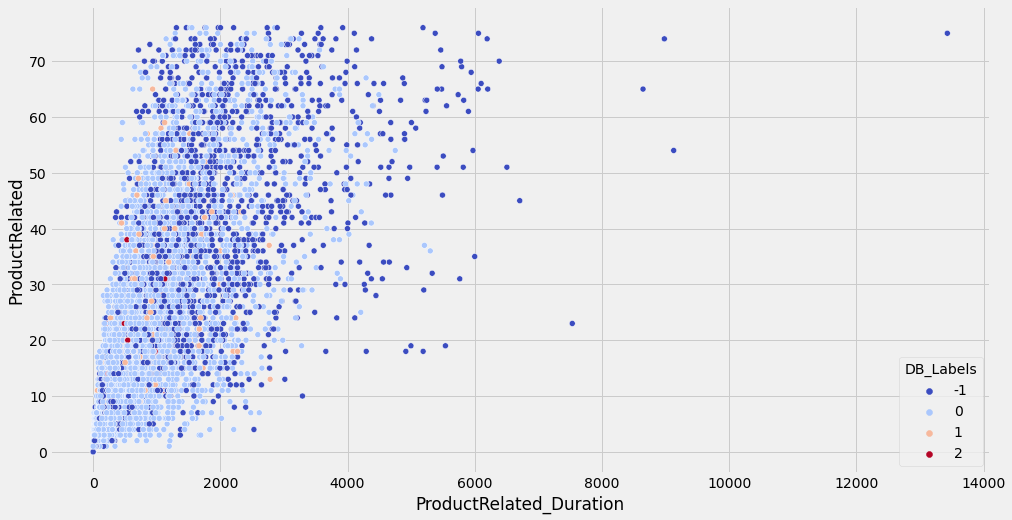

In [829]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=df['ProductRelated_Duration'],y=df['ProductRelated'],hue=label_df['DB_Labels'],palette='coolwarm')
plt.show()

The delineation between clusters is not exactly perfect, but that's the best we can do.

**Reducing Dimensions using Principal Component Analysis**


In [830]:
from sklearn.decomposition import PCA


In the following code, we try a PCA with no specified number of components to check which number has the best explanation of variation.

In [831]:
np.cumsum(PCA().fit(z_X).explained_variance_ratio_*100)

array([ 27.52725955,  45.03900028,  59.66121784,  72.46579025,
        82.78067911,  88.26722253,  92.72149447,  97.03930231,
       100.        ])

Scree plot

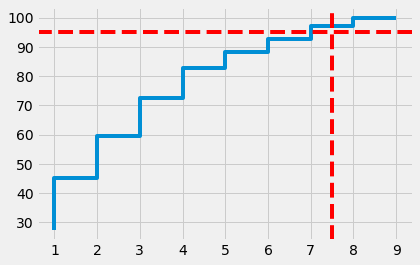

In [832]:
plt.step(y=np.cumsum(PCA().fit(z_X).explained_variance_ratio_*100),x=list(range(1,10)))
plt.xticks(list(range(1,10)))
plt.axhline(95,c='r',linestyle='--')
plt.axvline(7.5,c='r',linestyle='--')
plt.show()


We can see that 8 components would be great for dimension reduction.

**PCA model building**

In [833]:
PCA_model = PCA(n_components=8).fit(z_X)

In [834]:
PCA_model.transform(z_X)

array([[-1.75195216,  1.30055683, -0.21717539, ...,  0.14615861,
         0.03992903,  0.10233608],
       [-1.23839677,  0.24490028, -0.11133434, ..., -0.30019821,
         0.01616567,  0.95136466],
       [-1.15297859, -0.72103865,  0.34040012, ...,  0.44581829,
         0.01970989, -0.01709724],
       ...,
       [-1.20937907, -0.78268164,  0.43688163, ...,  0.32148223,
         0.00501477,  0.0990007 ],
       [-0.1610129 , -0.87444539,  0.67542995, ..., -0.46882841,
         0.28192645, -0.3166155 ],
       [-2.26893861,  0.51891528,  0.69906809, ...,  0.73525232,
        -0.0597158 , -1.38298655]])

In [835]:
reduced_X = pd.DataFrame(PCA_model.transform(z_X),columns=['PC'+str(i) for i in range(1,9)])

In [836]:
reduced_X

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-1.751952,1.300557,-0.217175,0.196487,0.273467,0.146159,0.039929,0.102336
1,-1.238397,0.244900,-0.111334,-0.142066,-0.084275,-0.300198,0.016166,0.951365
2,-1.152979,-0.721039,0.340400,-0.543405,-0.458079,0.445818,0.019710,-0.017097
3,-2.101809,0.578344,0.483897,-0.091991,-0.036317,0.865000,-0.043014,-1.487689
4,-1.255305,0.482943,-0.222021,-0.067494,0.004051,-0.246793,0.041265,0.976398
...,...,...,...,...,...,...,...,...
9037,-0.875021,0.079352,0.408389,-0.715771,-0.397207,0.305554,-0.695238,-0.483726
9038,1.273575,0.035842,-1.472942,0.521322,0.095638,0.115840,0.137084,-0.234031
9039,-1.209379,-0.782682,0.436882,-0.536729,-0.458725,0.321482,0.005015,0.099001
9040,-0.161013,-0.874445,0.675430,0.552540,-0.411970,-0.468828,0.281926,-0.316616


Choosing through Kaiser Criterion

In [837]:
val,vec = np.linalg.eig(z_X.cov())

In [838]:
val

array([2.47772738, 1.57623099, 1.31614514, 1.15253898, 0.92844268,
       0.26649227, 0.49384352, 0.38864569, 0.40092881])

According to Kaiser criterion, the eigen values of only 4 components are greater than 1

In [839]:
sorted(val)

[0.26649226517138913,
 0.3886456878174034,
 0.40092881480257764,
 0.4938435243214724,
 0.928442678447783,
 1.1525389827451977,
 1.316145139338913,
 1.5762309889873116,
 2.4777273834713744]

In [840]:
z_X.dot(vec)

,0,1,2,3,4,5,6,7,8
0,1.751952,1.300557,0.217175,-0.196487,0.273467,0.217647,-0.146159,-0.102336,-0.039929
1,1.238397,0.244900,0.111334,0.142066,-0.084275,-0.125448,0.300198,-0.951365,-0.016166
2,1.152979,-0.721039,-0.340400,0.543405,-0.458079,0.614999,-0.445818,0.017097,-0.019710
3,2.101809,0.578344,-0.483897,0.091991,-0.036317,-0.305934,-0.865000,1.487689,0.043014
4,1.255305,0.482943,0.222021,0.067494,0.004051,0.194408,0.246793,-0.976398,-0.041265
...,...,...,...,...,...,...,...,...,...
9037,0.875021,0.079352,-0.408389,0.715771,-0.397207,-0.238772,-0.305554,0.483726,0.695238
9038,-1.273575,0.035842,1.472942,-0.521322,0.095638,-0.679250,-0.115840,0.234031,-0.137084
9039,1.209379,-0.782682,-0.436882,0.536729,-0.458725,0.374163,-0.321482,-0.099001,-0.005015
9040,0.161013,-0.874445,-0.675430,-0.552540,-0.411970,0.030727,0.468828,0.316616,-0.281926


**Plotting the Principal components** (to understand the variation between them, with the existing label 'Revenue')

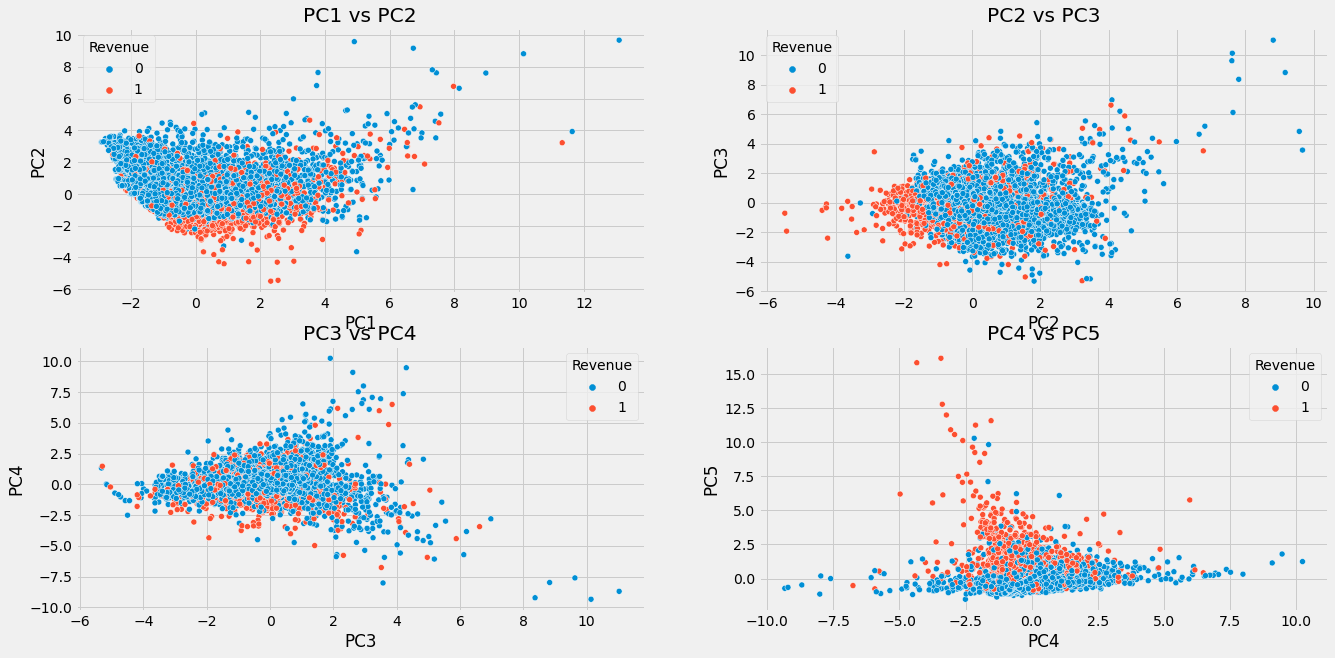

In [841]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.title('PC1 vs PC2')
sns.scatterplot(x=reduced_X['PC1'],y=reduced_X['PC2'],hue=df['Revenue'])
plt.subplot(2,2,2)
plt.title('PC2 vs PC3')
sns.scatterplot(x=reduced_X['PC2'],y=reduced_X['PC3'],hue=df['Revenue'])
plt.subplot(2,2,3)
plt.title('PC3 vs PC4')
sns.scatterplot(x=reduced_X['PC3'],y=reduced_X['PC4'],hue=df['Revenue'])
plt.subplot(2,2,4)
plt.title('PC4 vs PC5')
sns.scatterplot(x=reduced_X['PC4'],y=reduced_X['PC5'],hue=df['Revenue'])
plt.show()

Note that the cluster variation keeps decreasing from PC1 to PC5.

**Building a classification model**

In [842]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,KM_Labels
0,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,1,0,1
1,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2,1,3,Returning_Visitor,0,0,1
2,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.0,0.4,Feb,2,4,1,2,Returning_Visitor,0,0,1
3,0,0.0,0,0.0,3,395.000000,0.000000,0.066667,0.0,0.0,Feb,1,1,3,3,Returning_Visitor,0,0,1
4,0,0.0,0,0.0,16,407.750000,0.018750,0.025833,0.0,0.4,Feb,1,1,4,3,Returning_Visitor,0,0,1


In [843]:
from sklearn.linear_model import LogisticRegression

In [844]:
from sklearn.tree import DecisionTreeClassifier

In [845]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier

In [846]:
pip install XGBoost

Note: you may need to restart the kernel to use updated packages.


In [847]:
from xgboost import XGBClassifier

In [848]:
df['Revenue'].value_counts()

0    7557
1    1485
Name: Revenue, dtype: int64

In [849]:
label_df['KM_Labels'].replace({1:0,0:1},inplace=True)

In [850]:
df['KM_Labels'].value_counts()

1    6223
0    2819
Name: KM_Labels, dtype: int64

In [851]:
label_df.head()

,KM_Labels,Agg_Labels,DB_Labels
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [852]:
label_df['Agg_Labels'].value_counts()

0    6091
1    2951
Name: Agg_Labels, dtype: int64

Comparing K-Means and Agglomerative Clustering results with the original

In [853]:
from sklearn.metrics import classification_report,confusion_matrix

In [854]:
print(classification_report(df['Revenue'],label_df['KM_Labels']))

              precision    recall  f1-score   support

           0       0.87      0.72      0.79      7557
           1       0.25      0.47      0.32      1485

    accuracy                           0.68      9042
   macro avg       0.56      0.59      0.55      9042
weighted avg       0.77      0.68      0.71      9042



In [855]:
print(classification_report(df['Revenue'],label_df['Agg_Labels']))

              precision    recall  f1-score   support

           0       0.78      0.63      0.70      7557
           1       0.05      0.10      0.07      1485

    accuracy                           0.54      9042
   macro avg       0.42      0.37      0.38      9042
weighted avg       0.66      0.54      0.59      9042



This is a faulty exercise since one shouldn't compare the clusters with the pre-existig labels given, though I have tried it out of curiosity.

**Train Test Split**

In [856]:
from sklearn.model_selection import train_test_split

In [857]:
y = df['Revenue']

In [858]:
y.value_counts()

0    7557
1    1485
Name: Revenue, dtype: int64

In [859]:
X_train, X_test, y_train, y_test = train_test_split(z_X,y,train_size=0.7,random_state=100)

In [860]:
PC_X_train,PC_X_test, PC_y_train,PC_y_test = train_test_split(reduced_X,y,train_size=0.7,random_state=100)

In [861]:
from sklearn.metrics import classification_report

In [862]:
y_train.value_counts()

0    5294
1    1035
Name: Revenue, dtype: int64

In [863]:
 PC_y_train.value_counts()

0    5294
1    1035
Name: Revenue, dtype: int64

Now, we'll try building models using different algorithms, with PCA and without PCA.

**Logistic Regression Model**

Without PCA:

In [864]:
LogReg_model = LogisticRegression(random_state=100).fit(X_train,y_train)

In [865]:
LogReg_y_pred = LogReg_model.predict(X_test)

In [866]:
print(classification_report(y_test,LogReg_y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2263
           1       0.80      0.45      0.57       450

    accuracy                           0.89      2713
   macro avg       0.85      0.71      0.76      2713
weighted avg       0.88      0.89      0.88      2713



With PCA:

In [867]:
PCLogReg_model = LogisticRegression(random_state=100).fit(PC_X_train,y_train)

In [868]:
PCLogReg_y_pred = PCLogReg_model.predict(PC_X_test)

In [869]:
print(classification_report(y_test,PCLogReg_y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2263
           1       0.81      0.45      0.58       450

    accuracy                           0.89      2713
   macro avg       0.86      0.71      0.76      2713
weighted avg       0.88      0.89      0.88      2713



**DecisionTreeClassifier Model**

without PCA:

In [870]:
DecT_model = DecisionTreeClassifier(random_state=100).fit(X_train,y_train)

In [871]:
DecT_y_pred = DecT_model.predict(X_test)

In [872]:
print(classification_report(y_test, DecT_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2263
           1       0.63      0.63      0.63       450

    accuracy                           0.88      2713
   macro avg       0.78      0.78      0.78      2713
weighted avg       0.88      0.88      0.88      2713



with PCA:

In [873]:
PCDecT_model = DecisionTreeClassifier(random_state=100).fit(PC_X_train,y_train)

In [874]:
PCDecT_y_pred = PCDecT_model.predict(PC_X_test)

In [875]:
print(classification_report(y_test, PCDecT_y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2263
           1       0.54      0.57      0.56       450

    accuracy                           0.85      2713
   macro avg       0.73      0.74      0.73      2713
weighted avg       0.85      0.85      0.85      2713



**Random Forest Classifier**

Without PCA:

In [876]:
RandF_model = RandomForestClassifier(n_estimators=40,max_depth=6,random_state=100).fit(X_train,y_train)

In [877]:
RandF_y_pred = RandF_model.predict(X_test)

In [878]:
print(classification_report(y_test, RandF_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2263
           1       0.79      0.65      0.71       450

    accuracy                           0.91      2713
   macro avg       0.86      0.81      0.83      2713
weighted avg       0.91      0.91      0.91      2713



with PCA:

In [879]:
PCRandF_model = RandomForestClassifier(n_estimators=40,max_depth=6,random_state=100).fit(PC_X_train,y_train)

In [880]:
PCRandF_y_pred = PCRandF_model.predict(PC_X_test)

In [881]:
print(classification_report(y_test, PCRandF_y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2263
           1       0.87      0.44      0.58       450

    accuracy                           0.90      2713
   macro avg       0.88      0.71      0.76      2713
weighted avg       0.89      0.90      0.88      2713



**KNN classifier Model**

without PCA:

In [882]:
from sklearn.neighbors import KNeighborsClassifier

In [883]:
KNN_model = KNeighborsClassifier(n_neighbors=8).fit(X_train,y_train)

In [884]:
KNN_y_pred = KNN_model.predict(X_test)

In [885]:
print(classification_report(y_test, KNN_y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2263
           1       0.85      0.47      0.61       450

    accuracy                           0.90      2713
   macro avg       0.88      0.73      0.77      2713
weighted avg       0.89      0.90      0.89      2713



with PCA:

In [886]:
PCKNN_model = KNeighborsClassifier(n_neighbors=8).fit(PC_X_train,y_train)

In [887]:
PCKNN_y_pred = PCKNN_model.predict(PC_X_test)

In [888]:
print(classification_report(y_test, PCKNN_y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2263
           1       0.84      0.49      0.62       450

    accuracy                           0.90      2713
   macro avg       0.87      0.73      0.78      2713
weighted avg       0.89      0.90      0.89      2713



**AdaBoost Classifier Model**

Without PCA:

In [889]:
AdaB_model = AdaBoostClassifier(RandF_model,random_state=100).fit(X_train,y_train)

In [890]:
AdaB_y_pred = AdaB_model.predict(X_test)

In [891]:
print(classification_report(y_test, AdaB_y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      2263
           1       0.79      0.60      0.68       450

    accuracy                           0.91      2713
   macro avg       0.86      0.79      0.82      2713
weighted avg       0.90      0.91      0.90      2713



With PCA

In [892]:
PCAdaB_model = AdaBoostClassifier(PCRandF_model,random_state=100).fit(PC_X_train,y_train)

In [893]:
PCAdaB_y_pred = PCAdaB_model.predict(PC_X_test)

In [894]:
print(classification_report(y_test, PCAdaB_y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2263
           1       0.78      0.55      0.65       450

    accuracy                           0.90      2713
   macro avg       0.85      0.76      0.79      2713
weighted avg       0.89      0.90      0.89      2713



**Gradient Boost Classifier Model**

Without PCA:

In [895]:
GradB_model = GradientBoostingClassifier(random_state=100).fit(X_train,y_train)

In [896]:
GradB_y_pred = GradB_model.predict(X_test)

In [897]:
print(classification_report(y_test, GradB_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2263
           1       0.76      0.64      0.70       450

    accuracy                           0.91      2713
   macro avg       0.85      0.80      0.82      2713
weighted avg       0.90      0.91      0.90      2713



With PCA:

In [898]:
PCGradB_model = GradientBoostingClassifier(random_state=100).fit(PC_X_train,y_train)

In [899]:
PCGradB_y_pred = PCGradB_model.predict(PC_X_test)

In [900]:
print(classification_report(y_test, PCGradB_y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2263
           1       0.77      0.55      0.65       450

    accuracy                           0.90      2713
   macro avg       0.84      0.76      0.79      2713
weighted avg       0.89      0.90      0.89      2713



**XGBoost Classifier Model**

Without PCA:

In [901]:
XGB_model = XGBClassifier().fit(X_train,y_train)

In [902]:
XGB_y_pred = XGB_model.predict(X_test)

In [903]:
print(classification_report(y_test, XGB_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2263
           1       0.74      0.63      0.68       450

    accuracy                           0.90      2713
   macro avg       0.84      0.80      0.81      2713
weighted avg       0.90      0.90      0.90      2713



With PCA:

In [904]:
PCXGB_model = XGBClassifier().fit(PC_X_train,y_train)

In [905]:
PCXGB_y_pred = PCXGB_model.predict(PC_X_test)

In [906]:
print(classification_report(y_test, PCXGB_y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2263
           1       0.75      0.57      0.65       450

    accuracy                           0.90      2713
   macro avg       0.83      0.76      0.79      2713
weighted avg       0.89      0.90      0.89      2713



In [907]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score

In [908]:
all_model_preds = [LogReg_y_pred,DecT_y_pred,RandF_y_pred,KNN_y_pred,AdaB_y_pred,GradB_y_pred,XGB_y_pred]
    

**Building a comparison chart without PCA**

In [909]:
Comparison_Chart_without_PCA = pd.DataFrame({'Precision_Score':[precision_score(y_test,i) for i in all_model_preds],
              'Recall_Score':[recall_score(y_test,i) for i in all_model_preds],
             'F1_score':[f1_score(y_test,i) for i in all_model_preds],
              'Accuracy_Score':[accuracy_score(y_test,i) for i in all_model_preds]},
             index=['Logistic Regression','Decision Tree','Random Forest','KNN','AdaBoost','GradientBoost','XGBoost'])

The default scores are of class 1.

In [910]:
Comparison_Chart_without_PCA['TotalScore'] = Comparison_Chart_without_PCA['Precision_Score']+Comparison_Chart_without_PCA['Recall_Score']+Comparison_Chart_without_PCA['F1_score']+Comparison_Chart_without_PCA['Accuracy_Score']

In [911]:
Comparison_Chart_without_PCA

,Precision_Score,Recall_Score,F1_score,Accuracy_Score,TotalScore
Logistic Regression,0.804000,0.446667,0.574286,0.890158,2.715111
Decision Tree,0.625551,0.631111,0.628319,0.876152,2.761132
Random Forest,0.792916,0.646667,0.712362,0.913380,3.065325
KNN,0.854251,0.468889,0.605452,0.898636,2.827228
AdaBoost,0.788406,0.604444,0.684277,0.907482,2.984609
GradientBoost,0.761155,0.644444,0.697954,0.907482,3.011036
XGBoost,0.744125,0.633333,0.684274,0.903059,2.964792


I've added up all of precision score, recall score, f1 score and accuracy score in an effort to find which model is better than all of the rest, as a balance of all the scores being high.

We add an extra column to find the standard deviation between scores, so that all the scores of the models are close to each other.

In [912]:
Comparison_Chart_without_PCA['Variation between scores'] = Comparison_Chart_without_PCA.T.std()

In [913]:
Comparison_Chart_without_PCA

,Precision_Score,Recall_Score,F1_score,Accuracy_Score,TotalScore,Variation between scores
Logistic Regression,0.804000,0.446667,0.574286,0.890158,2.715111,0.927696
Decision Tree,0.625551,0.631111,0.628319,0.876152,2.761132,0.932310
Random Forest,0.792916,0.646667,0.712362,0.913380,3.065325,1.032940
KNN,0.854251,0.468889,0.605452,0.898636,2.827228,0.964671
AdaBoost,0.788406,0.604444,0.684277,0.907482,2.984609,1.007506
GradientBoost,0.761155,0.644444,0.697954,0.907482,3.011036,1.014716
XGBoost,0.744125,0.633333,0.684274,0.903059,2.964792,0.999572


**Building a comparison chart with PCA**

In [914]:
all_model_preds_with_PCA = [PCLogReg_y_pred,PCDecT_y_pred,PCRandF_y_pred,PCKNN_y_pred,PCAdaB_y_pred,PCGradB_y_pred,PCXGB_y_pred]

In [915]:
Comparison_Chart_with_PCA = pd.DataFrame({'Precision_Score':[precision_score(y_test,i) for i in all_model_preds_with_PCA],
              'Recall_Score':[recall_score(y_test,i) for i in all_model_preds_with_PCA],
             'F1_score':[f1_score(y_test,i) for i in all_model_preds_with_PCA],
              'Accuracy_Score':[accuracy_score(y_test,i) for i in all_model_preds_with_PCA]},
             index=['Logistic Regression_withPCA','Decision Tree_withPCA','Random Forest_withPCA','KNN_withPCA','AdaBoost_withPCA','GradientBoost_withPCA','XGBoost_withPCA'])

In [916]:
Comparison_Chart_with_PCA['TotalScore'] = Comparison_Chart_with_PCA['Precision_Score']+Comparison_Chart_with_PCA['Recall_Score']+Comparison_Chart_with_PCA['F1_score']+Comparison_Chart_with_PCA['Accuracy_Score']

In [917]:
Comparison_Chart_with_PCA

,Precision_Score,Recall_Score,F1_score,Accuracy_Score,TotalScore
Logistic Regression_withPCA,0.811245,0.448889,0.577969,0.891264,2.729367
Decision Tree_withPCA,0.543340,0.571111,0.556880,0.849244,2.520576
Random Forest_withPCA,0.871111,0.435556,0.580741,0.895687,2.783095
KNN_withPCA,0.835878,0.486667,0.615169,0.899005,2.836718
AdaBoost_withPCA,0.784127,0.548889,0.645752,0.900111,2.878878
GradientBoost_withPCA,0.773292,0.553333,0.645078,0.899005,2.870708
XGBoost_withPCA,0.750000,0.566667,0.645570,0.896793,2.859030


In [918]:
Comparison_Chart_with_PCA['Variation between scores'] = Comparison_Chart_with_PCA.T.std()

In [919]:
Comparison_Chart_with_PCA

,Precision_Score,Recall_Score,F1_score,Accuracy_Score,TotalScore,Variation between scores
Logistic Regression_withPCA,0.811245,0.448889,0.577969,0.891264,2.729367,0.932457
Decision Tree_withPCA,0.543340,0.571111,0.556880,0.849244,2.520576,0.854894
Random Forest_withPCA,0.871111,0.435556,0.580741,0.895687,2.783095,0.953570
KNN_withPCA,0.835878,0.486667,0.615169,0.899005,2.836718,0.965864
AdaBoost_withPCA,0.784127,0.548889,0.645752,0.900111,2.878878,0.974797
GradientBoost_withPCA,0.773292,0.553333,0.645078,0.899005,2.870708,0.971685
XGBoost_withPCA,0.750000,0.566667,0.645570,0.896793,2.859030,0.966879


**Comparison Chart**

In [920]:
Comparison_Chart = pd.concat([Comparison_Chart_without_PCA,Comparison_Chart_with_PCA],axis=0)

In [921]:
Comparison_Chart.sort_values(['TotalScore','Variation between scores'],ascending=[False,True])

,Precision_Score,Recall_Score,F1_score,Accuracy_Score,TotalScore,Variation between scores
Random Forest,0.792916,0.646667,0.712362,0.913380,3.065325,1.032940
GradientBoost,0.761155,0.644444,0.697954,0.907482,3.011036,1.014716
AdaBoost,0.788406,0.604444,0.684277,0.907482,2.984609,1.007506
XGBoost,0.744125,0.633333,0.684274,0.903059,2.964792,0.999572
AdaBoost_withPCA,0.784127,0.548889,0.645752,0.900111,2.878878,0.974797
GradientBoost_withPCA,0.773292,0.553333,0.645078,0.899005,2.870708,0.971685
XGBoost_withPCA,0.750000,0.566667,0.645570,0.896793,2.859030,0.966879
KNN_withPCA,0.835878,0.486667,0.615169,0.899005,2.836718,0.965864
KNN,0.854251,0.468889,0.605452,0.898636,2.827228,0.964671
Random Forest_withPCA,0.871111,0.435556,0.580741,0.895687,2.783095,0.953570


We can see from the above table, that PCA models barely score higher than non-PCA models respectively. GradientBoost model seems to be best model of the lot, since it has better spread amongst the scores.

    Thank You for taking the time out to go through my notebook. Any feedback is gladly appreciated.